<a href="https://colab.research.google.com/github/sarthakgupta/Deep-Learning-Hands-On/blob/master/GAN_HandsOn_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [69]:
from __future__ import absolute_import, division, print_function, unicode_literals
import os
import tensorflow as tf
# import cProfile
tf.enable_eager_execution()
tf.__version__
tf.executing_eagerly()


True

In [0]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import keras
from tensorflow.python.keras import backend as K

from tensorflow.keras import layers
import time

from IPython import display

In [0]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images-127.5)/127.5 # Normalize the images to [-1, 1]

In [0]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [0]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [0]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(256, use_bias=True, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Dense(512, use_bias=True))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Dense(784, activation=tf.nn.tanh, use_bias=True))
    model.add(layers.Reshape((28, 28, 1)))
    # assert model.output_shape == (None, 28, 28, 1)

    # model = tf.keras.Sequential()
    # model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    # model.add(layers.BatchNormalization())
    # model.add(layers.LeakyReLU())

    # model.add(layers.Reshape((7, 7, 256)))
    # assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size

    # model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    # assert model.output_shape == (None, 7, 7, 128)
    # model.add(layers.BatchNormalization())
    # model.add(layers.LeakyReLU())

    # model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    # assert model.output_shape == (None, 14, 14, 64)
    # model.add(layers.BatchNormalization())
    # model.add(layers.LeakyReLU())

    # model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    # assert model.output_shape == (None, 28, 28, 1)

    return model


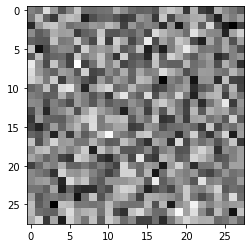

In [75]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
generated_image.shape
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [0]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Flatten())
    model.add(layers.Dense(512, use_bias=True))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Dense(256, use_bias=True))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Dense(64, activation=tf.nn.tanh, use_bias=True))
    model.add(layers.Dense(1, activation=tf.nn.tanh, use_bias=True))

    # model = tf.keras.Sequential()
    # model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
    #                                  input_shape=[28, 28, 1]))
    # model.add(layers.LeakyReLU())
    # model.add(layers.Dropout(0.3))

    # model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    # model.add(layers.LeakyReLU())
    # model.add(layers.Dropout(0.3))

    # model.add(layers.Flatten())
    # model.add(layers.Dense(1))

    return model
    

In [77]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.29043725]], shape=(1, 1), dtype=float32)


In [0]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [0]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [0]:
# checkpoint_dir = './training_checkpoints'
# checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
# checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
#                                  discriminator_optimizer=discriminator_optimizer,
#                                  generator=generator,
#                                  discriminator=discriminator)

In [0]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [0]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [0]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as we go
    # display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    # if (epoch + 1) % 15 == 0:
    #   checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  # display.clear_output(wait=True)
  generate_and_save_images(generator,epochs, seed)

In [0]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  # fig = plt.figure(figsize=(4,4))
  plt.figure(figsize=(4,4))
  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 255, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

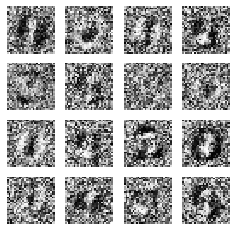

Time for epoch 1 is 18.8820641040802 sec


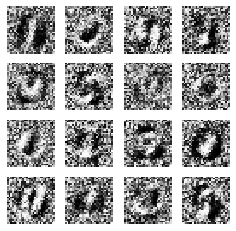

Time for epoch 2 is 15.51657509803772 sec


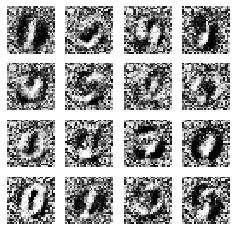

Time for epoch 3 is 15.754501342773438 sec


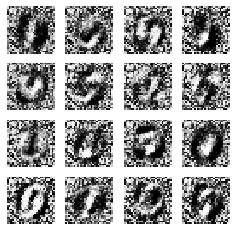

Time for epoch 4 is 15.562698125839233 sec


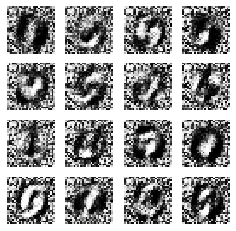

Time for epoch 5 is 15.384857177734375 sec


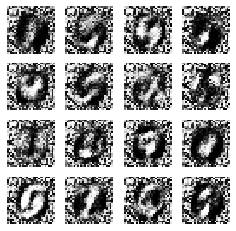

Time for epoch 6 is 15.381500482559204 sec


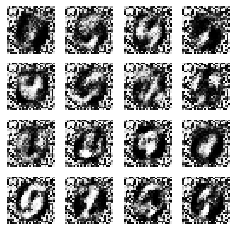

Time for epoch 7 is 15.484108686447144 sec


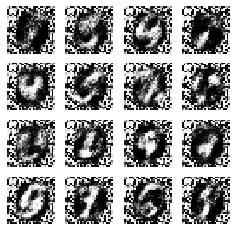

Time for epoch 8 is 15.629512071609497 sec


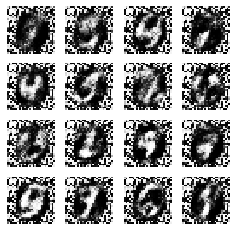

Time for epoch 9 is 15.379519939422607 sec


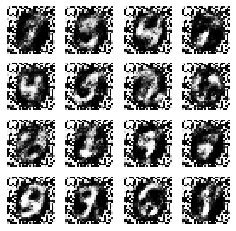

Time for epoch 10 is 15.281372308731079 sec


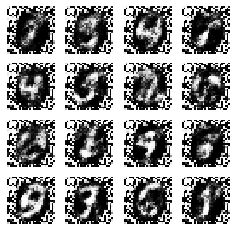

Time for epoch 11 is 15.385727643966675 sec


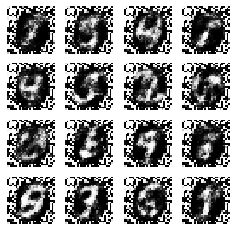

Time for epoch 12 is 15.332296371459961 sec


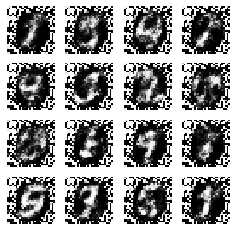

Time for epoch 13 is 15.597304821014404 sec


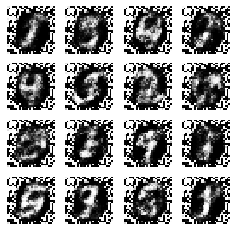

Time for epoch 14 is 15.331969022750854 sec


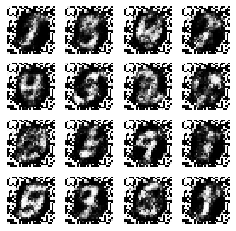

Time for epoch 15 is 15.652686834335327 sec


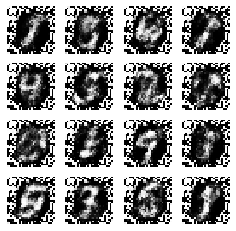

Time for epoch 16 is 15.668444633483887 sec


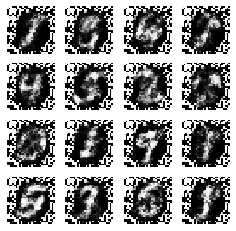

Time for epoch 17 is 15.583044052124023 sec


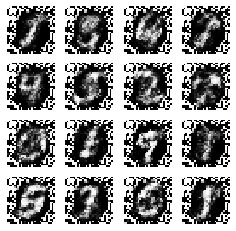

Time for epoch 18 is 15.677000284194946 sec


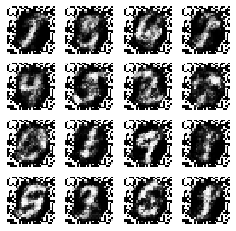

Time for epoch 19 is 15.441403150558472 sec


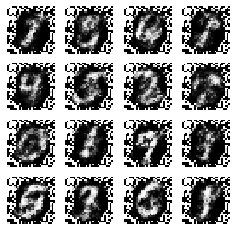

Time for epoch 20 is 15.427957534790039 sec


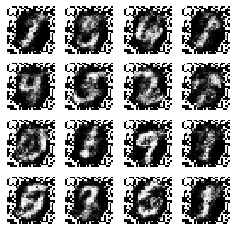

Time for epoch 21 is 15.35428762435913 sec


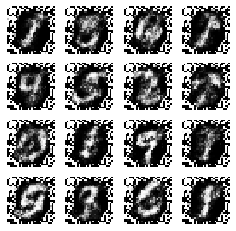

Time for epoch 22 is 15.572927236557007 sec


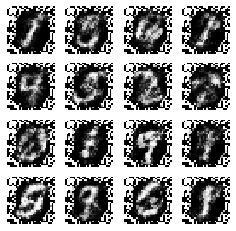

Time for epoch 23 is 15.797477960586548 sec


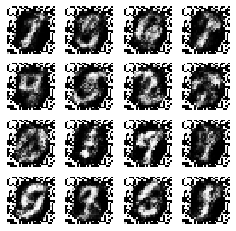

Time for epoch 24 is 15.849071741104126 sec


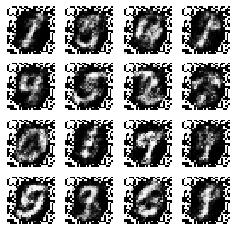

Time for epoch 25 is 15.465232133865356 sec


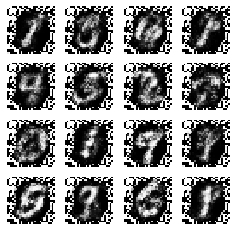

Time for epoch 26 is 15.616961240768433 sec


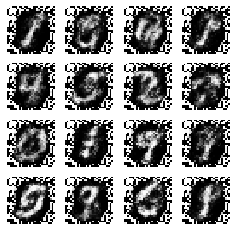

Time for epoch 27 is 15.502830505371094 sec


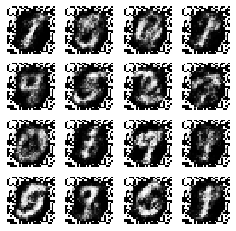

Time for epoch 28 is 15.766529083251953 sec


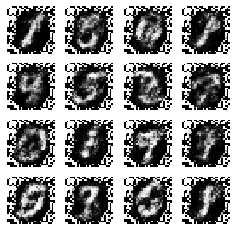

Time for epoch 29 is 15.42764949798584 sec


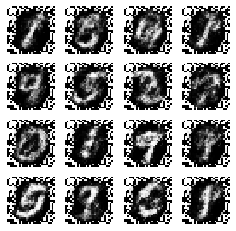

Time for epoch 30 is 15.478931665420532 sec


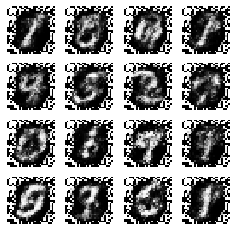

Time for epoch 31 is 15.431175947189331 sec


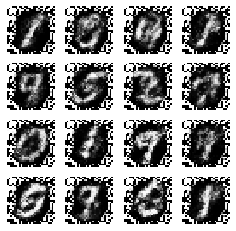

Time for epoch 32 is 15.645137310028076 sec


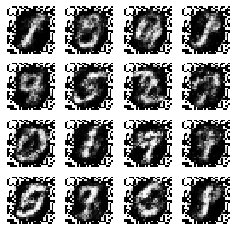

Time for epoch 33 is 15.829121828079224 sec


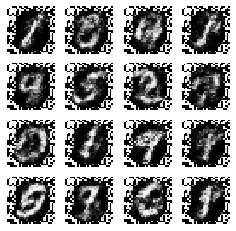

Time for epoch 34 is 15.593289136886597 sec


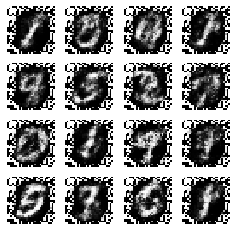

Time for epoch 35 is 15.932130098342896 sec


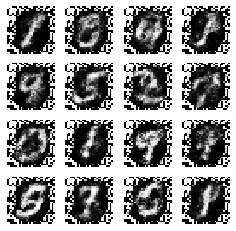

Time for epoch 36 is 15.636000633239746 sec


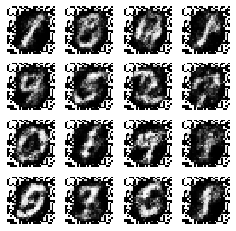

Time for epoch 37 is 15.452013969421387 sec


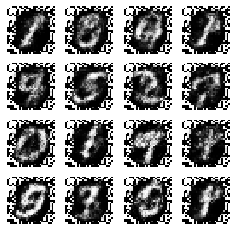

Time for epoch 38 is 15.776374101638794 sec


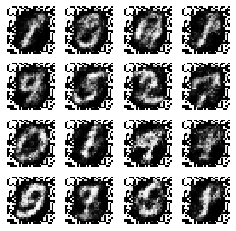

Time for epoch 39 is 15.429641723632812 sec


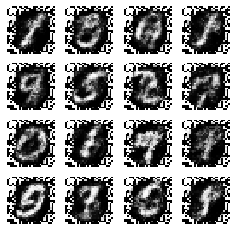

Time for epoch 40 is 15.554053544998169 sec


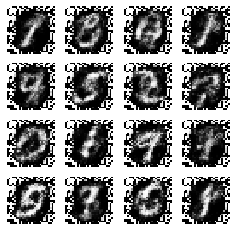

Time for epoch 41 is 15.512194395065308 sec


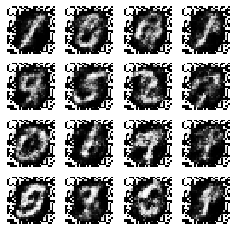

Time for epoch 42 is 15.491555452346802 sec


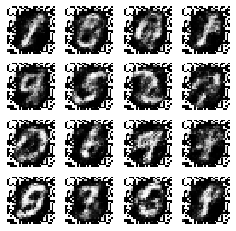

Time for epoch 43 is 15.850742816925049 sec


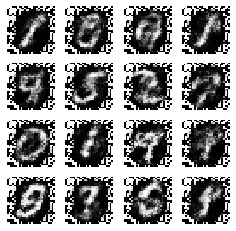

Time for epoch 44 is 15.742416858673096 sec


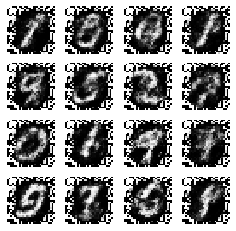

Time for epoch 45 is 15.489676475524902 sec


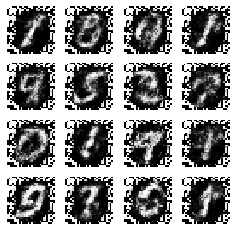

Time for epoch 46 is 15.466941118240356 sec


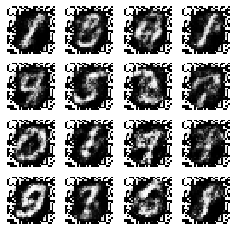

Time for epoch 47 is 15.47444486618042 sec


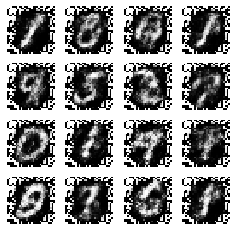

Time for epoch 48 is 15.740354061126709 sec


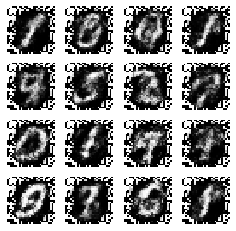

Time for epoch 49 is 15.464968204498291 sec


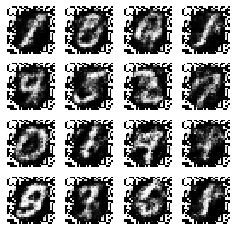

Time for epoch 50 is 15.480125904083252 sec


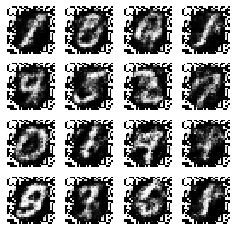

In [85]:
train(train_dataset, EPOCHS)